In [4]:
import os
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

RUNS_DIR = "runs"

LABEL_NAMES = {0: "UG", 1: "G", 2: "A"}

wrong_per_run = []
mismatch_counter = defaultdict(int)
confusion = np.zeros((3, 3), dtype=int)

for run in sorted(os.listdir(RUNS_DIR)):
    run_path = os.path.join(RUNS_DIR, run)
    if not os.path.isdir(run_path):
        continue

    auto_path = os.path.join(run_path, "labels_auto.json")
    corr_path = os.path.join(run_path, "labels_corrected.json")

    if not (os.path.exists(auto_path) and os.path.exists(corr_path)):
        continue

    with open(auto_path, "r") as f:
        auto_labels = json.load(f)

    with open(corr_path, "r") as f:
        corr_labels = json.load(f)

    assert len(auto_labels) == len(corr_labels), f"Grid size mismatch in {run}"

    wrong = 0
    for a, c in zip(auto_labels, corr_labels):
        confusion[a, c] += 1
        if a != c:
            wrong += 1
            mismatch_counter[(a, c)] += 1

    wrong_per_run.append(wrong)

# ============================================================
# PRINT SUMMARY
# ============================================================
print("\n===== Mismatch Summary =====")
print(f"Total wrong predictions: {sum(wrong_per_run)}\n")

for a in [0, 1, 2]:
    for c in [0, 1, 2]:
        if a != c:
            print(f"{LABEL_NAMES[a]} → {LABEL_NAMES[c]} : {mismatch_counter[(a, c)]}")



===== Mismatch Summary =====
Total wrong predictions: 115

UG → G : 25
UG → A : 8
G → UG : 13
G → A : 60
A → UG : 7
A → G : 2



===== Wrong predictions per plate =====
run_20251223_202520: 5
run_20251223_202842: 6
run_20251223_203053: 3
run_20251223_203321: 2
run_20251223_203519: 4
run_20251223_203742: 4
run_20251223_203913: 1
run_20251223_204045: 2
run_20251223_204208: 2
run_20251223_204338: 4
run_20251223_204604: 12
run_20251223_204752: 5
run_20251223_204928: 0
run_20251223_205101: 6
run_20251223_205239: 4
run_20251223_205428: 2
run_20251223_205547: 3
run_20251223_205654: 0
run_20251223_205842: 4
run_20251223_210042: 4
run_20251223_210425: 1
run_20251223_210630: 4
run_20251223_211011: 11
run_20251223_211131: 1
run_20251223_211309: 4
run_20251223_211558: 6
run_20251223_211738: 4
run_20251223_211856: 2
run_20251223_212114: 4
run_20251223_212238: 1
run_20251223_212502: 4

Total plates: 31
Average wrong per plate: 3.71
Median wrong per plate: 4.0
Max wrong in a plate: 12


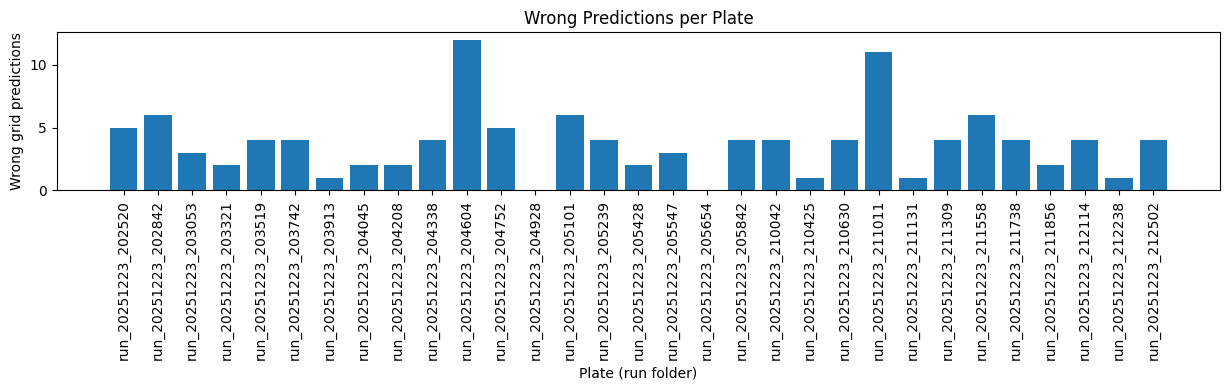

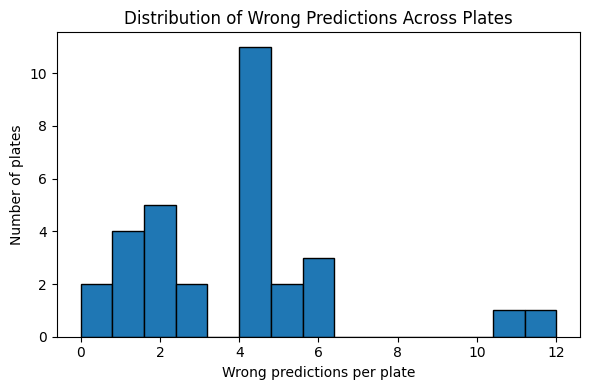

In [5]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# CONFIG
# ============================================================
RUNS_DIR = "runs"

# ============================================================
# COLLECT WRONG PER PLATE
# ============================================================
plate_names = []
wrong_per_plate = []

for run in sorted(os.listdir(RUNS_DIR)):
    run_path = os.path.join(RUNS_DIR, run)
    if not os.path.isdir(run_path):
        continue

    auto_path = os.path.join(run_path, "labels_auto.json")
    corr_path = os.path.join(run_path, "labels_corrected.json")

    if not (os.path.exists(auto_path) and os.path.exists(corr_path)):
        continue

    with open(auto_path, "r") as f:
        auto_labels = json.load(f)

    with open(corr_path, "r") as f:
        corr_labels = json.load(f)

    assert len(auto_labels) == len(corr_labels), f"Grid size mismatch in {run}"

    wrong = sum(a != c for a, c in zip(auto_labels, corr_labels))

    plate_names.append(run)
    wrong_per_plate.append(wrong)

# ============================================================
# SUMMARY PRINT
# ============================================================
print("\n===== Wrong predictions per plate =====")
for name, wrong in zip(plate_names, wrong_per_plate):
    print(f"{name}: {wrong}")

print(f"\nTotal plates: {len(wrong_per_plate)}")
print(f"Average wrong per plate: {np.mean(wrong_per_plate):.2f}")
print(f"Median wrong per plate: {np.median(wrong_per_plate):.1f}")
print(f"Max wrong in a plate: {np.max(wrong_per_plate)}")

# ============================================================
# PLOTTING
# ============================================================

# -------------------------------
# Bar plot (plate-wise)
# -------------------------------
plt.figure(figsize=(max(10, len(plate_names) * 0.4), 4))
plt.bar(plate_names, wrong_per_plate)
plt.xticks(rotation=90)
plt.ylabel("Wrong grid predictions")
plt.xlabel("Plate (run folder)")
plt.title("Wrong Predictions per Plate")
plt.tight_layout()
plt.show()

# -------------------------------
# Histogram (summary)
# -------------------------------
plt.figure(figsize=(6, 4))
plt.hist(wrong_per_plate, bins=15, edgecolor="black")
plt.xlabel("Wrong predictions per plate")
plt.ylabel("Number of plates")
plt.title("Distribution of Wrong Predictions Across Plates")
plt.tight_layout()
plt.show()



===== Tray-level summary =====
Total plates          : 31
Mean wrong / tray     : 3.71
Median wrong / tray   : 4.0
Max wrong in a tray   : 12

Overall accuracy    : 0.962
Mean plate accuracy   : 0.962

Confusion matrix (rows=true, cols=pred):

[[ 846   13    7]
 [  25 1926    2]
 [   8   60  151]]


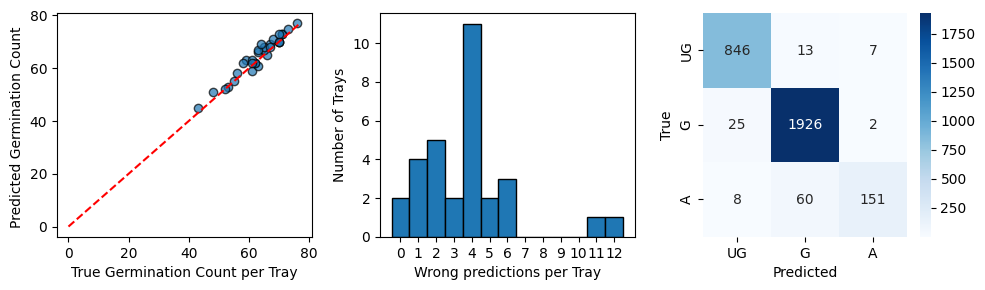

In [6]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# CONFIG
# ============================================================
RUNS_DIR = "runs"
LABEL_NAMES = {0: "UG", 1: "G", 2: "A"}

# ============================================================
# ACCUMULATORS
# ============================================================
plate_names = []
wrong_per_plate = []

true_G_counts = []
pred_G_counts = []
accuracies = []

confusion = np.zeros((3, 3), dtype=int)   # rows=true, cols=pred

# ============================================================
# SINGLE PASS OVER PLATES
# ============================================================
for run in sorted(os.listdir(RUNS_DIR)):
    run_path = os.path.join(RUNS_DIR, run)
    if not os.path.isdir(run_path):
        continue

    auto_path = os.path.join(run_path, "labels_auto.json")
    corr_path = os.path.join(run_path, "labels_corrected.json")

    if not (os.path.exists(auto_path) and os.path.exists(corr_path)):
        continue

    with open(auto_path) as f:
        pred = json.load(f)

    with open(corr_path) as f:
        true = json.load(f)

    assert len(pred) == len(true), f"Grid size mismatch in {run}"

    wrong = 0
    correct = 0
    true_G = 0
    pred_G = 0

    for t, p in zip(true, pred):
        confusion[t, p] += 1

        if t == 1:
            true_G += 1
        if p == 1:
            pred_G += 1

        if t != p:
            wrong += 1
        else:
            correct += 1

    plate_names.append(run)
    wrong_per_plate.append(wrong)
    true_G_counts.append(true_G)
    pred_G_counts.append(pred_G)
    accuracies.append(correct / len(true))

# ============================================================
# SUMMARY PRINT
# ============================================================
print("\n===== Tray-level summary =====")
print(f"Total plates          : {len(wrong_per_plate)}")
print(f"Mean wrong / tray     : {np.mean(wrong_per_plate):.2f}")
print(f"Median wrong / tray   : {np.median(wrong_per_plate):.1f}")
print(f"Max wrong in a tray   : {np.max(wrong_per_plate)}")

overall_accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print(f"\nOverall accuracy    : {overall_accuracy:.3f}")
print(f"Mean plate accuracy   : {np.mean(accuracies):.3f}")

print("\nConfusion matrix (rows=true, cols=pred):\n")
print(confusion)

# ============================================================
# PLOTTING
# ============================================================
fig = plt.figure(figsize=(10, 3))
gs = fig.add_gridspec(1, 3, width_ratios=[2, 2, 2])

# ------------------------------------------------------------
# (1) True G vs Predicted G — Scatter
# ------------------------------------------------------------
ax1 = fig.add_subplot(gs[0])

ax1.scatter(
    true_G_counts,
    pred_G_counts,
    alpha=0.7,
    edgecolor="black"
)

max_g = max(max(true_G_counts), max(pred_G_counts))
ax1.plot([0, max_g], [0, max_g], "r--", label="Perfect prediction")

ax1.set_xlabel("True Germination Count per Tray")
ax1.set_ylabel("Predicted Germination Count ")
#ax1.set_xscale('log')
#ax1.set_title("True G vs Predicted G (per plate)")
#ax1.legend()

# ------------------------------------------------------------
# (2) Wrong predictions per plate — Histogram
# ------------------------------------------------------------
ax2 = fig.add_subplot(gs[1])

min_w = min(wrong_per_plate)
max_w = max(wrong_per_plate)
bins = np.arange(min_w - 0.5, max_w + 1.5, 1)

ax2.hist(wrong_per_plate, bins=bins, edgecolor="black")
ax2.set_xlabel("Wrong predictions per Tray")
ax2.set_ylabel("Number of Trays")
#ax2.set_title("Wrong Prediction Distribution")
ax2.set_xticks(np.arange(min_w, max_w + 1))

# ------------------------------------------------------------
# (3) Confusion matrix
# ------------------------------------------------------------
ax3 = fig.add_subplot(gs[2])
sns.heatmap(
    confusion,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[LABEL_NAMES[i] for i in range(3)],
    yticklabels=[LABEL_NAMES[i] for i in range(3)],
    ax=ax3
)

ax3.set_xlabel("Predicted")
ax3.set_ylabel("True")
#ax3.set_title("Confusion Matrix (All Plates)")

plt.tight_layout()
plt.show()




Binary Confusion Matrix (Good vs Bad):

[[1926   27]
 [  73 1012]]


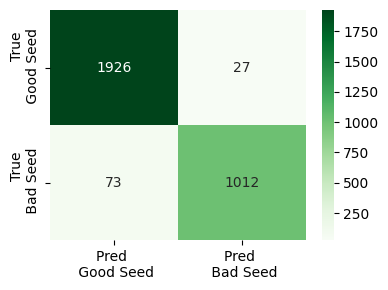

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Original 3-class confusion matrix
confusion_3 = np.array([
    [846,   13,   7],   # True UG
    [  25, 1926,  2],   # True G
    [ 8,  60, 151],   # True A
])

# Indices
UG, G, A = 0, 1, 2

# Build 2x2 confusion matrix: rows=true, cols=pred
confusion_2 = np.zeros((2, 2), dtype=int)

# True GOOD (G)
confusion_2[0, 0] = confusion_3[G, G]                     # G → G
confusion_2[0, 1] = confusion_3[G, UG] + confusion_3[G, A] # G → Bad

# True BAD (UG + A)
confusion_2[1, 0] = (
    confusion_3[UG, G] +
    confusion_3[A,  G]
)                                                           # Bad → G

confusion_2[1, 1] = (
    confusion_3[UG, UG] + confusion_3[UG, A] +
    confusion_3[A,  UG] + confusion_3[A,  A]
)                                                           # Bad → Bad

print("\nBinary Confusion Matrix (Good vs Bad):\n")
print(confusion_2)

plt.figure(figsize=(4, 3))
sns.heatmap(
    confusion_2,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Pred \n Good Seed", "Pred \n Bad Seed"],
    yticklabels=["True \n Good Seed", "True \n Bad Seed"]
)
#plt.title("Confusion Matrix: Good vs Bad Seeds")
plt.tight_layout()
plt.show()



In [8]:
import numpy as np

# ============================================================
# INPUT: 3-class confusion matrix (rows=true, cols=pred)
# ============================================================
confusion = np.array([
    [846,   13,   7],   # True UG
    [  25, 1926,  2],   # True G
    [ 8,  60, 151],   # True A
])

LABELS = ["UG", "G", "A"]

# ============================================================
# CLASSIFICATION REPORT FROM CONFUSION MATRIX
# ============================================================
def classification_report_from_confusion(confusion, labels):
    confusion = np.asarray(confusion)
    n_classes = confusion.shape[0]

    support = confusion.sum(axis=1)
    predicted = confusion.sum(axis=0)
    correct = np.diag(confusion)

    precision = np.zeros(n_classes)
    recall = np.zeros(n_classes)
    f1 = np.zeros(n_classes)

    for i in range(n_classes):
        precision[i] = correct[i] / predicted[i] if predicted[i] > 0 else 0.0
        recall[i]    = correct[i] / support[i]   if support[i] > 0 else 0.0
        if precision[i] + recall[i] > 0:
            f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
        else:
            f1[i] = 0.0

    accuracy = correct.sum() / confusion.sum()

    macro_precision = precision.mean()
    macro_recall = recall.mean()
    macro_f1 = f1.mean()

    weighted_precision = np.average(precision, weights=support)
    weighted_recall = np.average(recall, weights=support)
    weighted_f1 = np.average(f1, weights=support)

    # ========================================================
    # PRINT REPORT (sklearn style)
    # ========================================================
    print("\nClassification Report")
    print("-" * 72)
    print(f"{'Class':<10}{'Precision':>12}{'Recall':>10}{'F1-score':>10}{'Support':>10}")
    print("-" * 72)

    for i, label in enumerate(labels):
        print(
            f"{label:<10}"
            f"{precision[i]:>12.3f}"
            f"{recall[i]:>10.3f}"
            f"{f1[i]:>10.3f}"
            f"{support[i]:>10d}"
        )

    print("-" * 72)
    print(
        f"{'Accuracy':<10}"
        f"{accuracy:>34.3f}"
        f"{support.sum():>10d}"
    )

    print(
        f"{'Macro avg':<10}"
        f"{macro_precision:>12.3f}"
        f"{macro_recall:>10.3f}"
        f"{macro_f1:>10.3f}"
        f"{support.sum():>10d}"
    )

    print(
        f"{'Weighted avg':<10}"
        f"{weighted_precision:>12.3f}"
        f"{weighted_recall:>10.3f}"
        f"{weighted_f1:>10.3f}"
        f"{support.sum():>10d}"
    )


# ============================================================
# RUN
# ============================================================
classification_report_from_confusion(confusion, LABELS)



Classification Report
------------------------------------------------------------------------
Class        Precision    Recall  F1-score   Support
------------------------------------------------------------------------
UG               0.962     0.977     0.970       866
G                0.963     0.986     0.975      1953
A                0.944     0.689     0.797       219
------------------------------------------------------------------------
Accuracy                               0.962      3038
Macro avg        0.957     0.884     0.914      3038
Weighted avg       0.962     0.962     0.960      3038



Binary Classification Report (Good vs Bad)
--------------------------------------------------
Precision (Good) : 0.963
Recall    (Good) : 0.986
F1-score  (Good) : 0.975
Accuracy         : 0.967

Confusion Matrix:
[[1926   27]
 [  73 1012]]


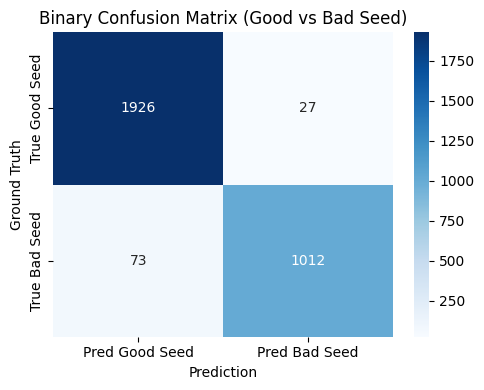

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================
# ORIGINAL 3-CLASS CONFUSION (rows=true, cols=pred)
# ============================================================
# Classes: [UG, G, A]
confusion_3 = np.array([
    [846,   13,   7],   # True UG
    [  25, 1926,  2],   # True G
    [ 8,  60, 151],   # True A
])

# ============================================================
# CONVERT TO BINARY: Good (G) vs Bad (UG + A)
# ============================================================
# Binary confusion:
# [[True Good → Pred Good, True Good → Pred Bad],
#  [True Bad  → Pred Good, True Bad  → Pred Bad]]

TP = confusion_3[1, 1]                             # True G predicted G
FN = confusion_3[1, 0] + confusion_3[1, 2]         # True G predicted (UG or A)
FP = confusion_3[0, 1] + confusion_3[2, 1]         # True (UG or A) predicted G
TN = (
    confusion_3[0, 0] + confusion_3[0, 2] +
    confusion_3[2, 0] + confusion_3[2, 2]
)

confusion_2 = np.array([
    [TP, FN],
    [FP, TN]
])

# ============================================================
# METRICS
# ============================================================
precision = TP / (TP + FP)
recall    = TP / (TP + FN)
f1        = 2 * precision * recall / (precision + recall)
accuracy  = (TP + TN) / confusion_2.sum()

# ============================================================
# PRINT SUMMARY
# ============================================================
print("\nBinary Classification Report (Good vs Bad)")
print("-" * 50)
print(f"Precision (Good) : {precision:.3f}")
print(f"Recall    (Good) : {recall:.3f}")
print(f"F1-score  (Good) : {f1:.3f}")
print(f"Accuracy         : {accuracy:.3f}")
print("\nConfusion Matrix:")
print(confusion_2)

# ============================================================
# PLOT CONFUSION MATRIX
# ============================================================
plt.figure(figsize=(5, 4))
sns.heatmap(
    confusion_2,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred Good Seed", "Pred Bad Seed"],
    yticklabels=["True Good Seed", "True Bad Seed"]
)

plt.title("Binary Confusion Matrix (Good vs Bad Seed)")
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.tight_layout()
plt.show()
